In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, Adadelta, Adagrad, RMSprop
import random
from torchsummary import summary
import seaborn as sns

In [2]:
fmnist = datasets.FashionMNIST(root='./data', train=True, download=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
tr_images.shape, tr_targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [3]:
val_fmnist = datasets.FashionMNIST(root='./data', train=False, download=True)
val_images = val_fmnist.data
val_targets = val_fmnist.targets
val_images.shape, val_targets.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x.to(device), y.to(device)
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [8]:
def get_model():
    SNet = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)        
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(SNet.parameters(), lr=1e-3)
    return SNet, loss_fn, optimizer

In [7]:
# No of parameters in the convolutional layer = (kernel_size * kernel_size * input_channels + 1) * output_channels
((3 *3 *64) + 1) * 128


73856

In [10]:
def train_batch(x, y, SNet, optimizer, loss_fn):
    prediction = SNet(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [11]:
@torch.no_grad()
def accuracy(X, y, SNet):
    SNet.eval()
    prediction = SNet(X)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [16]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [14]:
@torch.no_grad()
def val_loss(x, y, SNet, loss_fn):
    SNet.eval()
    prediction = SNet(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


In [17]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [18]:
summary(SNet, torch.zeros(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [19]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        X, y = batch
        batch_loss = train_batch(X, y, SNet, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        X, y = batch
        is_correct = accuracy(X, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        X, y = batch
        val_is_correct = accuracy(X, y, SNet)
        validation_loss = val_loss(X, y, SNet, loss_fn)
    print(f"Epoch: {epoch} train_loss: {train_epoch_loss}, val_loss: {validation_loss}")
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
Epoch: 0 train_loss: 0.432690828837951, val_loss: 0.3308287262916565
1
Epoch: 1 train_loss: 0.28064448147416116, val_loss: 0.297976553440094
2
Epoch: 2 train_loss: 0.2328646343956391, val_loss: 0.29553884267807007
3
Epoch: 3 train_loss: 0.19734306150128444, val_loss: 0.2562035024166107
4
Epoch: 4 train_loss: 0.16776796538929145, val_loss: 0.24557998776435852


In [21]:
train_accuracies, val_accuracies

([0.89165, 0.90815, 0.9142, 0.9379, 0.9526833333333333],
 [0.8809, 0.8925, 0.8902, 0.9097, 0.9131])

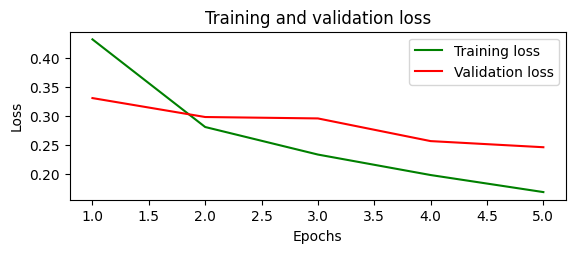

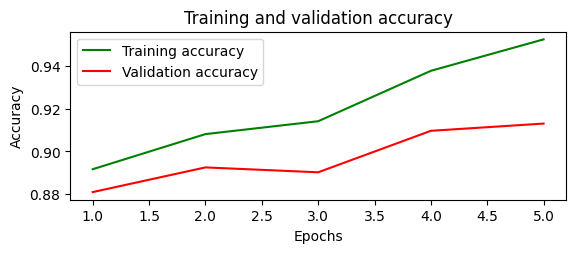

In [23]:
epochs = np.arange(5) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

[[8.6503911e-05 7.7386394e-06 1.7768173e-06 3.7326397e-06 6.5563422e-06
  8.1414837e-01 3.2016480e-06 1.8514889e-01 5.7299103e-04 2.0258516e-05]]


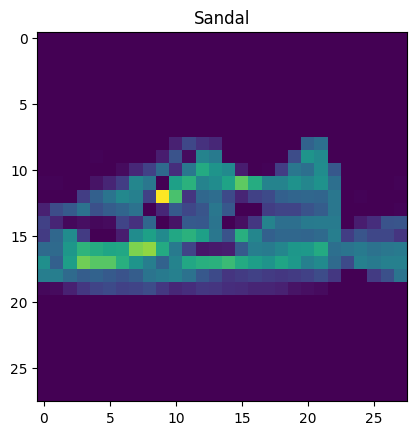

[[1.4001682e-05 2.3461960e-06 3.2754798e-07 7.2154944e-07 1.4806462e-06
  8.4110755e-01 1.0960728e-06 1.5882646e-01 2.5391084e-05 2.0637282e-05]]


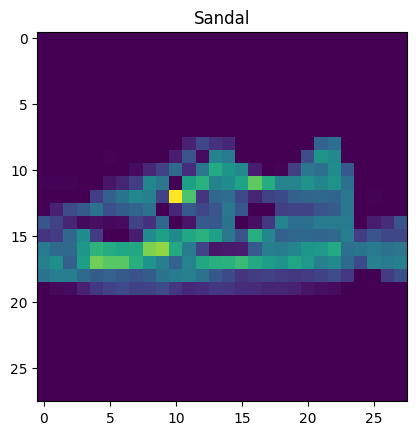

[[9.2434657e-06 3.1628747e-06 7.6354900e-07 1.2649714e-06 8.3909691e-07
  4.6750063e-01 8.3409208e-07 5.3242671e-01 7.2699931e-06 4.9245780e-05]]


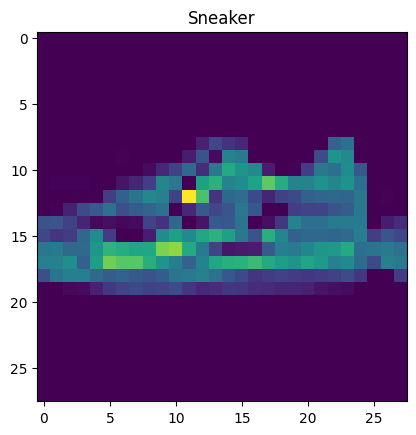

[[1.7292618e-06 9.3435409e-07 2.3294484e-07 5.5682693e-07 2.1673601e-07
  5.6762200e-02 1.7759037e-07 9.4322526e-01 1.6213430e-06 7.0630654e-06]]


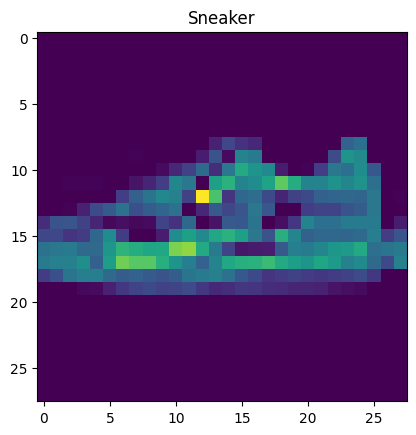

[[3.8543450e-07 1.2384958e-06 3.1658735e-07 3.5599780e-07 1.1943284e-07
  2.5066251e-03 2.5719660e-07 9.9748421e-01 2.6952688e-07 6.2003655e-06]]


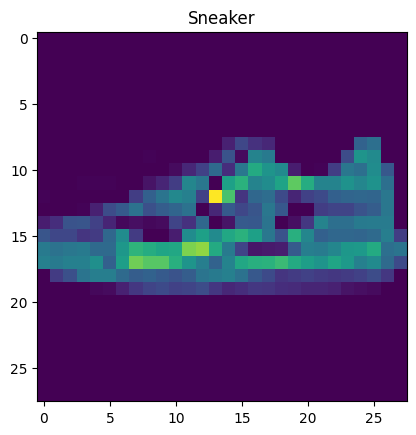

[[3.8370132e-07 7.2932727e-07 1.8567532e-07 8.9111403e-08 7.3212107e-08
  7.8181271e-04 1.1652972e-07 9.9921530e-01 1.6007533e-07 1.1660860e-06]]


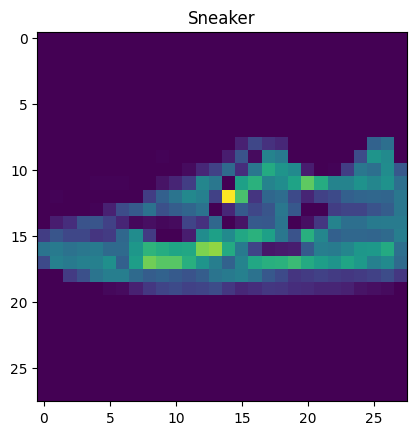

[[4.2722482e-07 5.0628421e-07 4.3366862e-07 2.5733877e-07 4.1142289e-07
  6.1048998e-04 3.6792113e-07 9.9938321e-01 9.1622780e-07 2.8834636e-06]]


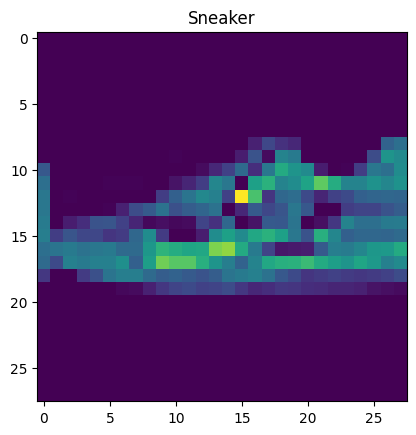

[[1.3505239e-06 1.8420626e-06 1.2300003e-06 9.2364195e-07 1.7590581e-06
  2.4262823e-03 1.7103109e-06 9.9754339e-01 2.8580787e-06 1.8677038e-05]]


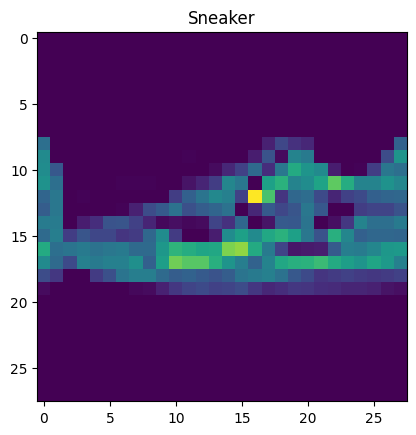

[[3.64365515e-05 3.04204696e-06 6.62533876e-06 2.66109146e-06
  1.23709760e-05 3.17724124e-02 1.32577552e-05 9.67801332e-01
  2.41508475e-04 1.10356865e-04]]


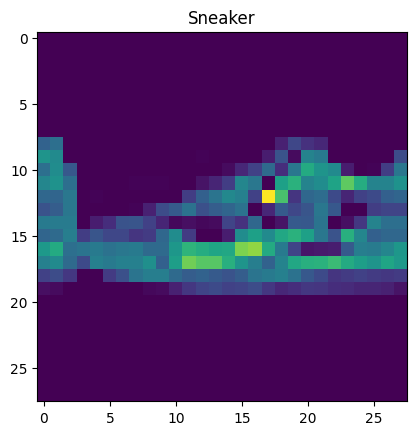

[[3.4612496e-04 5.5984201e-06 3.9143979e-05 1.2307143e-05 5.9965871e-05
  7.9179205e-02 1.4084537e-04 9.1377372e-01 5.7953913e-03 6.4769259e-04]]


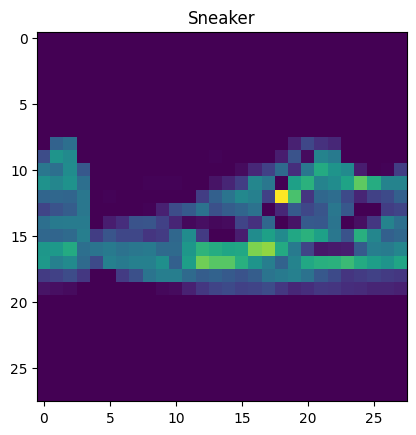

[[3.2793279e-03 1.0408354e-04 7.0384220e-04 8.1486331e-05 5.0074630e-04
  5.9121889e-01 9.7803702e-04 3.5251129e-01 4.0029183e-02 1.0593175e-02]]


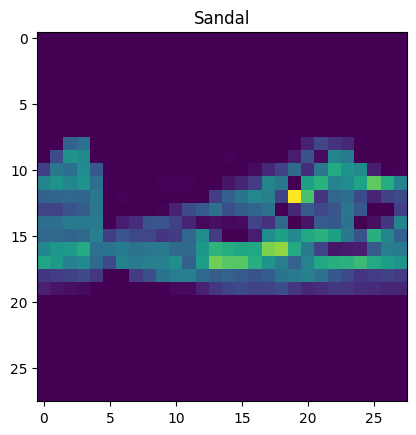

In [28]:
preds = []
ix = 10001
for px in range(-5, 6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1, 1, 28, 28).to(device)
    np_output = SNet(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    print(pred)
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

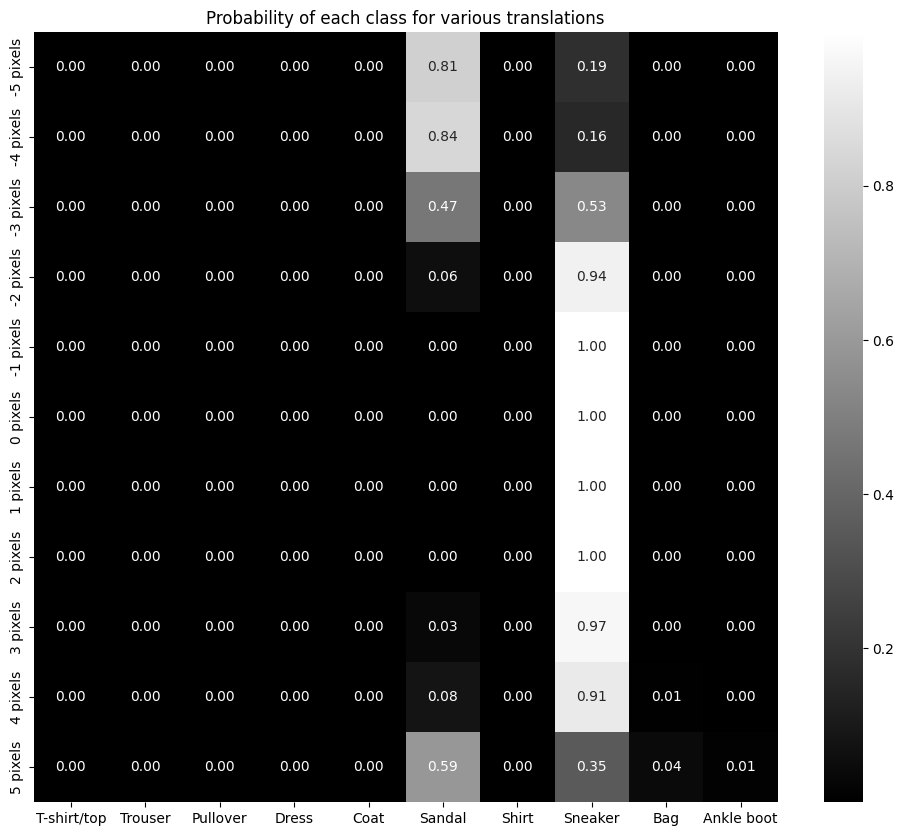

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title("Probability of each class for various translations")
sns.heatmap(np.array(preds).reshape(11, 10), annot=True, ax=ax, 
            fmt=".2f", xticklabels=fmnist.classes,
            yticklabels=[str(i)+str(" pixels")\
            for i in range(-5, 6)], cmap="gray")